## Huấn luyện mô hình

### Từ tập dữ liệu đã được chia thành 2 bộ (x_train, y_train) và (x_test, y_test), ta sẽ sử dụng những thuật toán học máy để huấn luyện chúng  

In [9]:
import pandas as pd

x_train = pd.read_csv('data/x_train.csv').values
x_test = pd.read_csv('data/x_test.csv').values
y_train = pd.read_csv('data/y_train.csv').values
y_test = pd.read_csv('data/y_test.csv').values


In [10]:
x_train.shape

(17634, 10)

### Khởi tạo hàm evaluate_classification
Hàm evaluate_classification để đánh giá mô hình phân loại của tập train và test dựa trên thuật toán được lựa chọn. Hàm có nhiệm vụ thực hiện tính toán các chỉ số phân loại: Accuracy, Precision, Recall

- Accuracy (Độ chính xác): Phần trăm các mẫu được dự đoán đúng trên tổng số mẫu.
- Precision (Độ chính xác của lớp Positive):  Trong số các mẫu được dự đoán là Positive thì có bao nhiêu phần trăm là đúng
- Recall ( Độ nhạy): Trong số các mẫu thực sự là Positive mô hình phát hiện được bao nhiêu phần trăm

In [11]:
from sklearn import metrics
import matplotlib.pyplot as plt

def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
    
    train_precision = metrics.precision_score(y_train, model.predict(X_train))
    test_precision = metrics.precision_score(y_test, model.predict(X_test))
    
    train_recall = metrics.recall_score(y_train, model.predict(X_train))
    test_recall = metrics.recall_score(y_test, model.predict(X_test))
    
    print(f"Training Accuracy {name}: {train_accuracy * 100:.2f}%  Test Accuracy {name}: {test_accuracy * 100:.2f}%")
    print(f"Training Precision {name}: {train_precision * 100:.2f}%  Test Precision {name}: {test_precision * 100:.2f}%")
    print(f"Training Recall {name}: {train_recall * 100:.2f}%  Test Recall {name}: {test_recall * 100:.2f}%")

    
    actual = y_test
    predicted = model.predict(X_test)

    # ma trận nhầm lẫn
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'attack'])
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.grid(False)
    cm_display.plot(ax=ax)

### Sử dụng thuật toán Logistic Regression

f:\2024.1\Machine Learning\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy Logistic Regression: 93.38%  Test Accuracy Logistic Regression: 92.92%
Training Precision Logistic Regression: 91.68%  Test Precision Logistic Regression: 91.56%
Training Recall Logistic Regression: 96.29%  Test Recall Logistic Regression: 95.64%


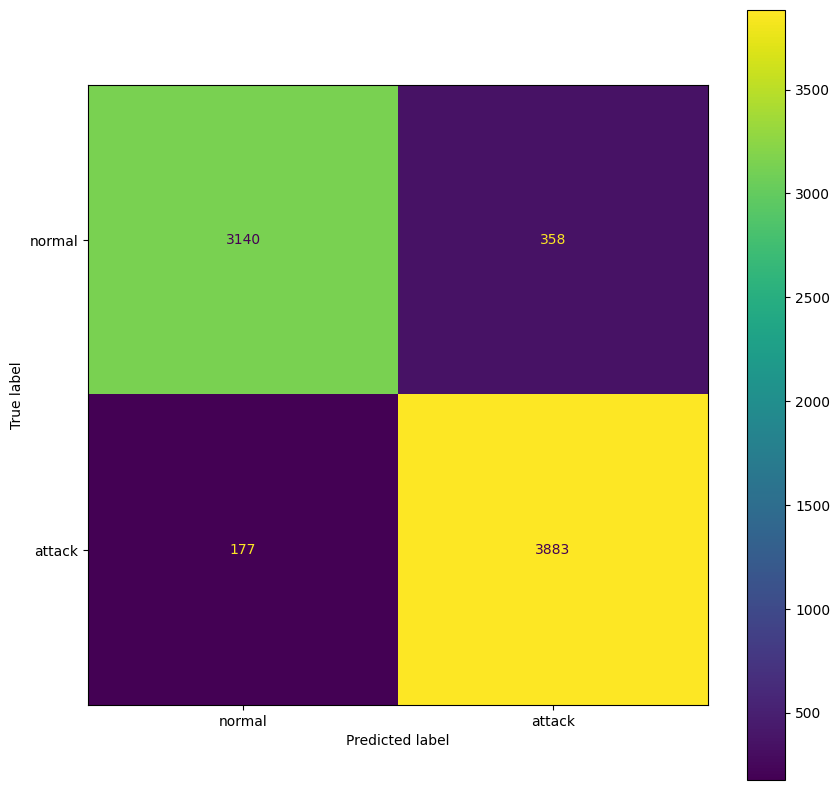

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(x_train, y_train)
evaluate_classification(lr, "Logistic Regression", x_train, x_test, y_train, y_test)

### Sử dụng thuật toán K-nearest neighbors

f:\2024.1\Machine Learning\venv\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Training Accuracy KNeighborsClassifier: 97.54%  Test Accuracy KNeighborsClassifier: 97.43%
Training Precision KNeighborsClassifier: 97.66%  Test Precision KNeighborsClassifier: 97.59%
Training Recall KNeighborsClassifier: 97.73%  Test Recall KNeighborsClassifier: 97.64%


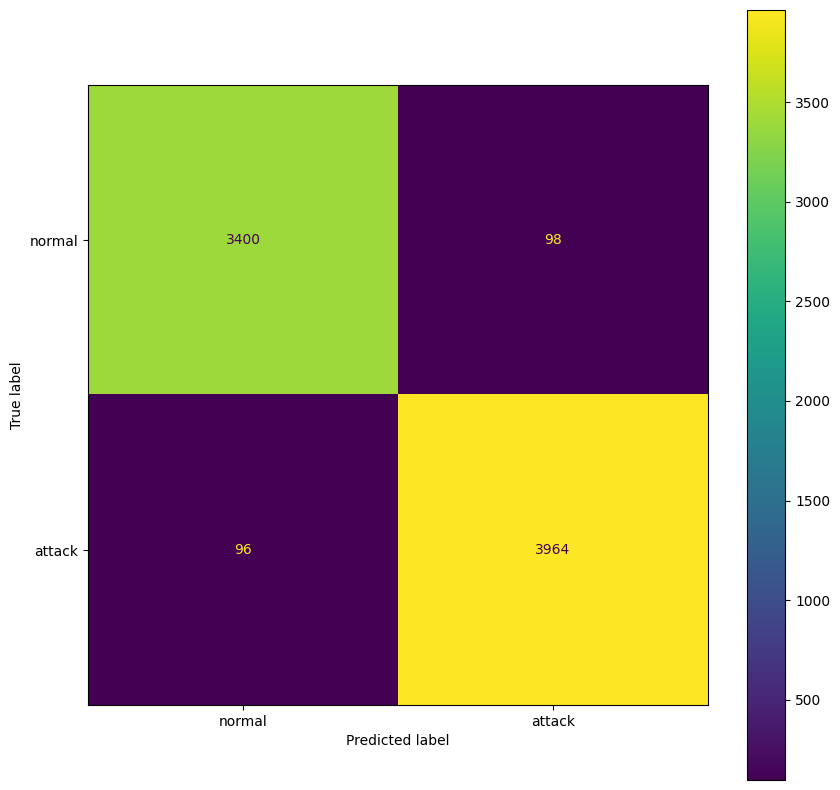

In [12]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors=20).fit(x_train, y_train)
evaluate_classification(knn, "KNeighborsClassifier", x_train, x_test, y_train, y_test)

### Tối ưu cách chọn số lượng điểm n_neighbors bằng thư viện optuna

In [13]:
def objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [14]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [15]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [16]:
study_KNN = optuna.create_study(direction='maximize')
study_KNN.optimize(objective, n_trials=1)
print(study_KNN.best_trial)

f:\2024.1\Machine Learning\venv\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


FrozenTrial(number=0, state=1, values=[0.9789626885419423], datetime_start=datetime.datetime(2024, 12, 7, 17, 55, 26, 611167), datetime_complete=datetime.datetime(2024, 12, 7, 17, 55, 27, 252473), params={'KNN_n_neighbors': 8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=0, value=None)


In [17]:
KNN_model = KNeighborsClassifier(n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors'])
KNN_model.fit(x_train, y_train)

KNN_train, KNN_test = KNN_model.score(x_train, y_train), KNN_model.score(x_test, y_test)

print(f"Train Score: {KNN_train* 100:.2f}%")
print(f"Test Score: {KNN_test* 100:.2f}%")

f:\2024.1\Machine Learning\venv\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Train Score: 98.34%
Test Score: 97.90%


- Nhận xét: Độ chính xác của mô hình đã được tăng lên 

In [ ]:
lr = LogisticRegression().fit(x_train, y_train)
evaluate_classification(lr, "Logistic Regression", x_train, x_test, y_train, y_test)